# Importowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import ppscore as pps
import networkx as nx
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway
from scipy.stats import kruskal
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import time
from scipy.stats import mannwhitneyu, kruskal
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.utils import resample
import xgboost as xgb







pd.set_option('mode.chained_assignment', None)


# Wczytanie Danych

In [2]:
data = pd.read_csv('/home/krzysztof/Kaczmarek/Projket2/ICPSR_27521/DS0001/27521-0001-Data.tsv',sep='\t')

In [3]:
columns_to_check = [
    "DEPRESSIONINDEX", "DEP_EPISODE", "MDELastYr", "ANYTXRXMDE", 
    "CATAG2", "CATAG3", "CATAG7", "IRSEX", "NEWRACE2", "ANYINDEX", "YO_MDEA6",
    "MJANDCOKE", "ILLICITDRUGUSE", "LSYRILLICIT", "COKECRACK", "OTHERILLICIT", 
    "MARJLTYR", "MJCOKELY", "COCCRKLY", "MJGT12MO", "COCGT12MO", "ANYGT12MO", 
    "ALCFMFPB", "IREDUC2", "EDU_DUMMY", "INCOME", "INCOME_R", "POVERTY", 
    "IRPRVHLT", "WORKFORCE", "EMPSTAT4", "REVERSEPOP", "MOVESPY2", "CACHAR", 
    "CATYPE", "CRIMEHIST", "ANYSDRUG", "ANYATTACK", "ANYTHEFT", "NUMARREST", 
    "HEALTH2", "SCHDSICK", "SCHDSKIP", "TXLCAD", "DSTNCALM", "DSTTIRE", 
    "DSTSITST", "DSTDEPRS", "DSTCHEER", "DSTNRVOS", "YOWRSATP", "YOWRSPLN", 
    "ADWRDLOT", "ADWRSTHK", "YO_MDEA4", "ADWRSLEP", "ADWRSMOR", "YO_MDEA3", 
    "ADWRELES", "IRMARIT", "NOMARR2", "RKIDSHH", "MARRIED", "CHILDRENINHOME"
]

available_columns = [col for col in columns_to_check if col in data.columns]

df_filtered = data[available_columns]

# Rozkład danych w zmiennej DEPRESSIONINDEX

In [4]:

def plot_percentage_barplot(data,column_name):
    depression = data[column_name]
    if depression.isnull().sum() == 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        value_counts = depression.value_counts(dropna=False)
        labels = value_counts.index.to_series().fillna('Missing Data').astype(str)
        colors = plt.cm.Paired.colors[:len(value_counts)]
        
        axes[0].bar(labels, value_counts.values, color=colors) 
        axes[0].set_title(f'{column_name} - Bar Chart')
        axes[0].set_ylabel('Count')
        axes[0].set_xlabel(column_name)
        
        def autopct_format(pct):
            return f'{pct:.1f}%' if pct >= 2 else ''  # Wyświetlaj tylko procenty >= 1%

        axes[1].pie(
            value_counts.values, 
            labels=labels, 
            autopct=autopct_format, 
            startangle=90, 
            colors=colors
        )
        axes[1].set_title(f'{column_name} - Pie Chart')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Występują brakujące wartości w kolumnie {column_name} w ilości: {depression.isnull().sum()}")

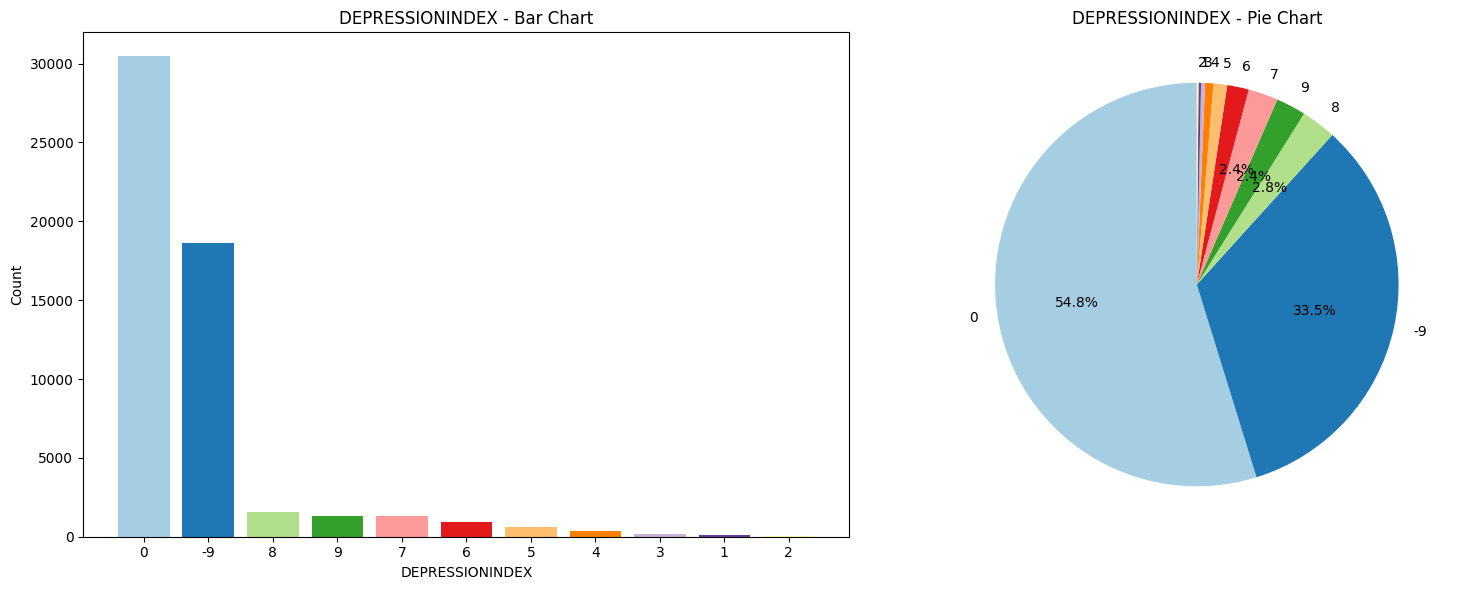

In [5]:
plot_percentage_barplot(df_filtered, 'DEPRESSIONINDEX')

# Podział na depresje somatyczną i niesomatyczną

In [6]:
#YO_MDEA4 - 1-tak, 2-nie - Sen
#YO_MDEA3 - 1-tak, 2-nie - Apetyt
#YO_MDEA6 - 1-tak, 2-nie - Zmęczenie

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'].between(1, 9)) & 
       (df_filtered['YO_MDEA4'] == 1) & 
       (df_filtered['YO_MDEA3'] == 1) & 
       (df_filtered['YO_MDEA6'] == 1), 'Somatic'] = 2

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'] == 0), 'Somatic'] = 0

df_filtered.loc[(df_filtered['DEPRESSIONINDEX'].between(1, 9)) & 
       ((df_filtered['YO_MDEA4'] == 2) |
       (df_filtered['YO_MDEA3'] == 2) | 
       (df_filtered['YO_MDEA6'] == 2)), 'Somatic'] = 1

df_filtered['Somatic'].replace(np.nan, -1, inplace=True)

# Somatic - 2 - depresja somatyczn, 1 - brak depresji somatycznej, 0 - brak depresji

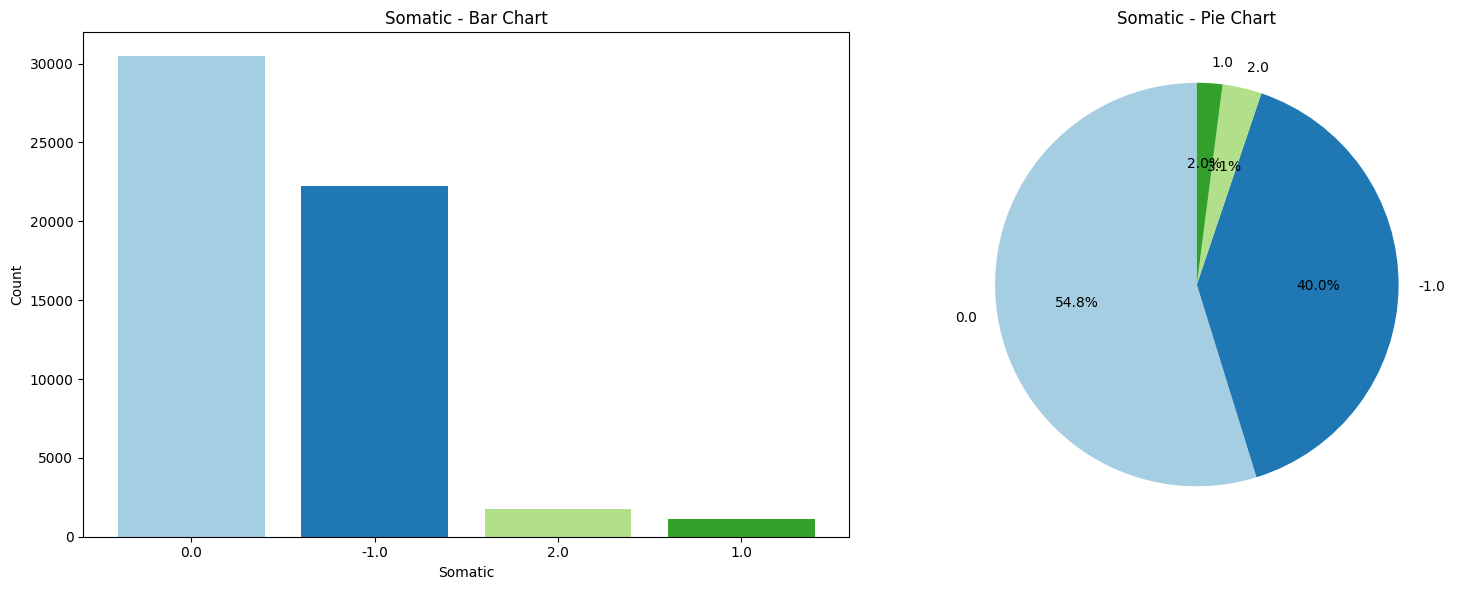

In [7]:
plot_percentage_barplot(df_filtered, 'Somatic')

# Operacje na brakach w danych

## Sprawdzenie które kolumny występują tylko dla pozytywnych wartości w DEPRESSIONINDEX

In [8]:
df_filtered['DEPRESSIONINDEX'] = df_filtered['DEPRESSIONINDEX'].replace(-9, np.nan)
df_filtered = df_filtered.dropna(subset=['DEPRESSIONINDEX'])


In [9]:
pd.set_option('display.max_rows', None)

check_nan_data = df_filtered.copy()

check_nan_data[check_nan_data == -1] = np.nan
check_nan_data[check_nan_data == -9] = np.nan

check_nan_data['YO_MDEA4'].replace([99, 98, 94, 97], np.nan, inplace=True)
check_nan_data['MOVESPY2'].replace([998, 997, 994], np.nan, inplace=True)
check_nan_data['SCHDSKIP'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['SCHDSICK'].replace([89, 90, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ALCFMFPB'].replace([94, 97, 98], np.nan, inplace=True)
check_nan_data['ADWRSTHK'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['NOMARR2'].replace([94, 97, 99], np.nan, inplace=True)
check_nan_data['ADWRELES'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YO_MDEA3'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YO_MDEA6'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRSMOR'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRSLEP'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['ADWRDLOT'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YOWRSPLN'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['YOWRSATP'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTNRVOS'].replace([85, 89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTCHEER'].replace([85, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTDEPRS'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTSITST'].replace([94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTTIRE'].replace([89, 94, 97, 98, 99], np.nan, inplace=True)
check_nan_data['DSTNCALM'].replace([94, 97, 98, 99], np.nan, inplace=True)

missing_percentage = check_nan_data.isna().mean() * 100


In [10]:
missing_percentage_without_depression = check_nan_data[check_nan_data['DEPRESSIONINDEX'] == 0].isna().mean() * 100
missing_percentage_with_depression = check_nan_data[check_nan_data['DEPRESSIONINDEX'] != 0].isna().mean() * 100

In [68]:
comparison_df = pd.DataFrame({
    'Column': missing_percentage_without_depression.index,
    'Without Depression': missing_percentage_without_depression.values,
    'With Depression': missing_percentage_with_depression.values,
    'Overall': missing_percentage.values,
    'Difference': missing_percentage_with_depression.values - missing_percentage_without_depression.values
})
comparison_df = comparison_df.sort_values(by='Overall', ascending=False)
comparison_df

,Column,Without Depression,With Depression,Overall,Difference
45,DSTDEPRS,100.000000,100.000000,100.000000,0.000000
44,DSTSITST,100.000000,100.000000,100.000000,0.000000
43,DSTTIRE,100.000000,100.000000,100.000000,0.000000
42,DSTNCALM,100.000000,100.000000,100.000000,0.000000
41,TXLCAD,98.650645,96.867803,98.336579,-1.782842
54,ADWRSMOR,100.000000,90.204207,98.274370,-9.795793
48,YOWRSATP,100.000000,77.982497,96.121389,-22.017503
49,YOWRSPLN,100.000000,77.890373,96.105161,-22.109627
55,YO_MDEA3,100.000000,55.688623,92.194093,-44.311377
52,YO_MDEA4,100.000000,55.489022,92.158931,-44.510978


In [12]:
comparison_df = comparison_df[comparison_df['Difference'].abs() > 10]
Depression_column=comparison_df['Column'].values.tolist()
Depression_column

['YOWRSATP',
 'YOWRSPLN',
 'YO_MDEA3',
 'YO_MDEA4',
 'YO_MDEA6',
 'ADWRELES',
 'ADWRSTHK',
 'ADWRSLEP',
 'ADWRDLOT',
 'Somatic']

## Usunięcie kolumn gdzie występuje ponad 60% danych brakujących

In [13]:
columns_to_drop = missing_percentage[(missing_percentage > 60)].index

for column in Depression_column:
    if column in columns_to_drop:
        columns_to_drop = columns_to_drop.drop(column)

check_nan_data.drop(columns=columns_to_drop, inplace=True)

df_filtered = check_nan_data
df_filtered['DEPRESSIONINDEX'] = df_filtered['DEPRESSIONINDEX'].astype(int)

df_filtered_without_DEPRESSIONINDEX = check_nan_data.drop(columns=['DEPRESSIONINDEX'])

## Uzupełnienie brakujących danych

In [14]:
df_filtered.drop(columns=['SCHDSICK', 'SCHDSKIP', 'DSTCHEER', 'DSTNRVOS'], inplace=True)
column_with_missing_values = df_filtered.columns[df_filtered.isna().any()].tolist()

column_with_missing_values

['ANYTXRXMDE',
 'ANYINDEX',
 'YO_MDEA6',
 'COKECRACK',
 'MJGT12MO',
 'COCGT12MO',
 'ANYGT12MO',
 'ALCFMFPB',
 'WORKFORCE',
 'MOVESPY2',
 'CACHAR',
 'CATYPE',
 'CRIMEHIST',
 'ANYSDRUG',
 'ANYATTACK',
 'ANYTHEFT',
 'NUMARREST',
 'HEALTH2',
 'YOWRSATP',
 'YOWRSPLN',
 'ADWRDLOT',
 'ADWRSTHK',
 'YO_MDEA4',
 'ADWRSLEP',
 'YO_MDEA3',
 'ADWRELES',
 'RKIDSHH',
 'Somatic']

In [15]:
columns_without_missing_values = df_filtered.columns[~df_filtered.isna().any()]
df_without_missing_values = df_filtered[columns_without_missing_values]

X = df_without_missing_values.drop(columns=['DEPRESSIONINDEX']) 
y = df_without_missing_values['DEPRESSIONINDEX']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

method = 0
low_mse = 1000

def impute_missing_values(df, column):
    low_mse = 1000
    for method in range(3):
        # print(f'Column: {column} - Method: {method}')
        if method == 0:
            imputer = SimpleImputer(strategy='median')
        if method == 1:
            imputer = SimpleImputer(strategy='mean')
        if method == 2:
            imputer = KNNImputer(n_neighbors=3)

        df_sampled = df_without_missing_values.sample(frac=0.2, random_state=42)

        df_imputed = pd.DataFrame(imputer.fit_transform(df_sampled), columns=df_sampled.columns)

        X = df_imputed.drop(columns=['DEPRESSIONINDEX']) 
        y = df_imputed['DEPRESSIONINDEX']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)

        if mse < low_mse:
            low_mse = mse
            best_method = imputer

        method += 1

    return low_mse, best_method


for column in column_with_missing_values:
    df_without_missing_values = pd.concat([df_without_missing_values, df_filtered[column]], axis=1)
    mse, imputer = impute_missing_values(df_without_missing_values, column)
    print(f'Mean Squared Error: {mse}, Method: {imputer}, Column: {column}')
    df_without_missing_values[column] = imputer.fit_transform(df_without_missing_values[[column]])



Mean Squared Error: 6.860431632312846
Mean Squared Error: 4.462898823150048, Method: KNNImputer(n_neighbors=3), Column: ANYTXRXMDE
Mean Squared Error: 4.458359781969938, Method: SimpleImputer(strategy='median'), Column: ANYINDEX
Mean Squared Error: 2.7530739670408266, Method: KNNImputer(n_neighbors=3), Column: YO_MDEA6
Mean Squared Error: 4.558662070418194, Method: SimpleImputer(strategy='median'), Column: COKECRACK
Mean Squared Error: 4.536305349786841, Method: KNNImputer(n_neighbors=3), Column: MJGT12MO
Mean Squared Error: 4.557512453115936, Method: SimpleImputer(strategy='median'), Column: COCGT12MO
Mean Squared Error: 4.530438007936648, Method: KNNImputer(n_neighbors=3), Column: ANYGT12MO
Mean Squared Error: 4.554175551847159, Method: SimpleImputer(), Column: ALCFMFPB
Mean Squared Error: 4.552634197037098, Method: KNNImputer(n_neighbors=3), Column: WORKFORCE
Mean Squared Error: 4.5529782783696335, Method: KNNImputer(n_neighbors=3), Column: MOVESPY2
Mean Squared Error: 4.55567952699

In [16]:
column_with_missing_values = df_without_missing_values.columns[df_without_missing_values.isna().any()].tolist()
nan_counts = df_without_missing_values[column_with_missing_values].isna().sum()
nan_counts

Series([], dtype: float64)

In [17]:
num_columns = df_without_missing_values.shape[1]
print(num_columns)

num_columns = df_filtered.shape[1]
print(num_columns)

df_filtered = df_without_missing_values.copy()

52
52


## Podział na zbiór do predykcji depresji i zbiór do predykcji skali depresji

In [18]:
Depression_column

['YOWRSATP',
 'YOWRSPLN',
 'YO_MDEA3',
 'YO_MDEA4',
 'YO_MDEA6',
 'ADWRELES',
 'ADWRSTHK',
 'ADWRSLEP',
 'ADWRDLOT',
 'Somatic']

In [19]:
df_filtered_for_depressio_scale = df_filtered.copy()
for column in Depression_column:
    if column in df_filtered.columns:
        df_filtered.drop(columns=column, inplace=True)

In [20]:
print(df_filtered.shape)
print(df_filtered_for_depressio_scale.shape)

(36972, 42)
(36972, 52)
0        1.459754
1        1.459754
2        1.459754
3        1.459754
4        1.459754
5        1.000000
7        1.459754
8        1.459754
9        1.459754
10       1.459754
12       1.459754
13       1.459754
14       1.459754
15       1.459754
16       1.459754
18       1.459754
20       1.459754
21       1.459754
22       1.459754
23       1.459754
24       1.459754
25       1.459754
27       1.459754
28       1.459754
29       1.000000
30       1.459754
31       1.459754
32       1.459754
33       1.459754
34       1.459754
35       1.459754
36       1.459754
37       1.459754
39       1.459754
41       1.459754
43       1.459754
44       1.459754
45       1.459754
46       2.000000
47       1.459754
48       1.459754
49       1.459754
51       1.459754
52       1.459754
53       1.459754
54       2.000000
55       1.459754
56       1.459754
58       1.459754
59       1.459754
60       1.459754
61       1.459754
63       1.000000
64       2.000000
65  

# Predictive Power Score dla zmiennej DEPRESSIONINDEX

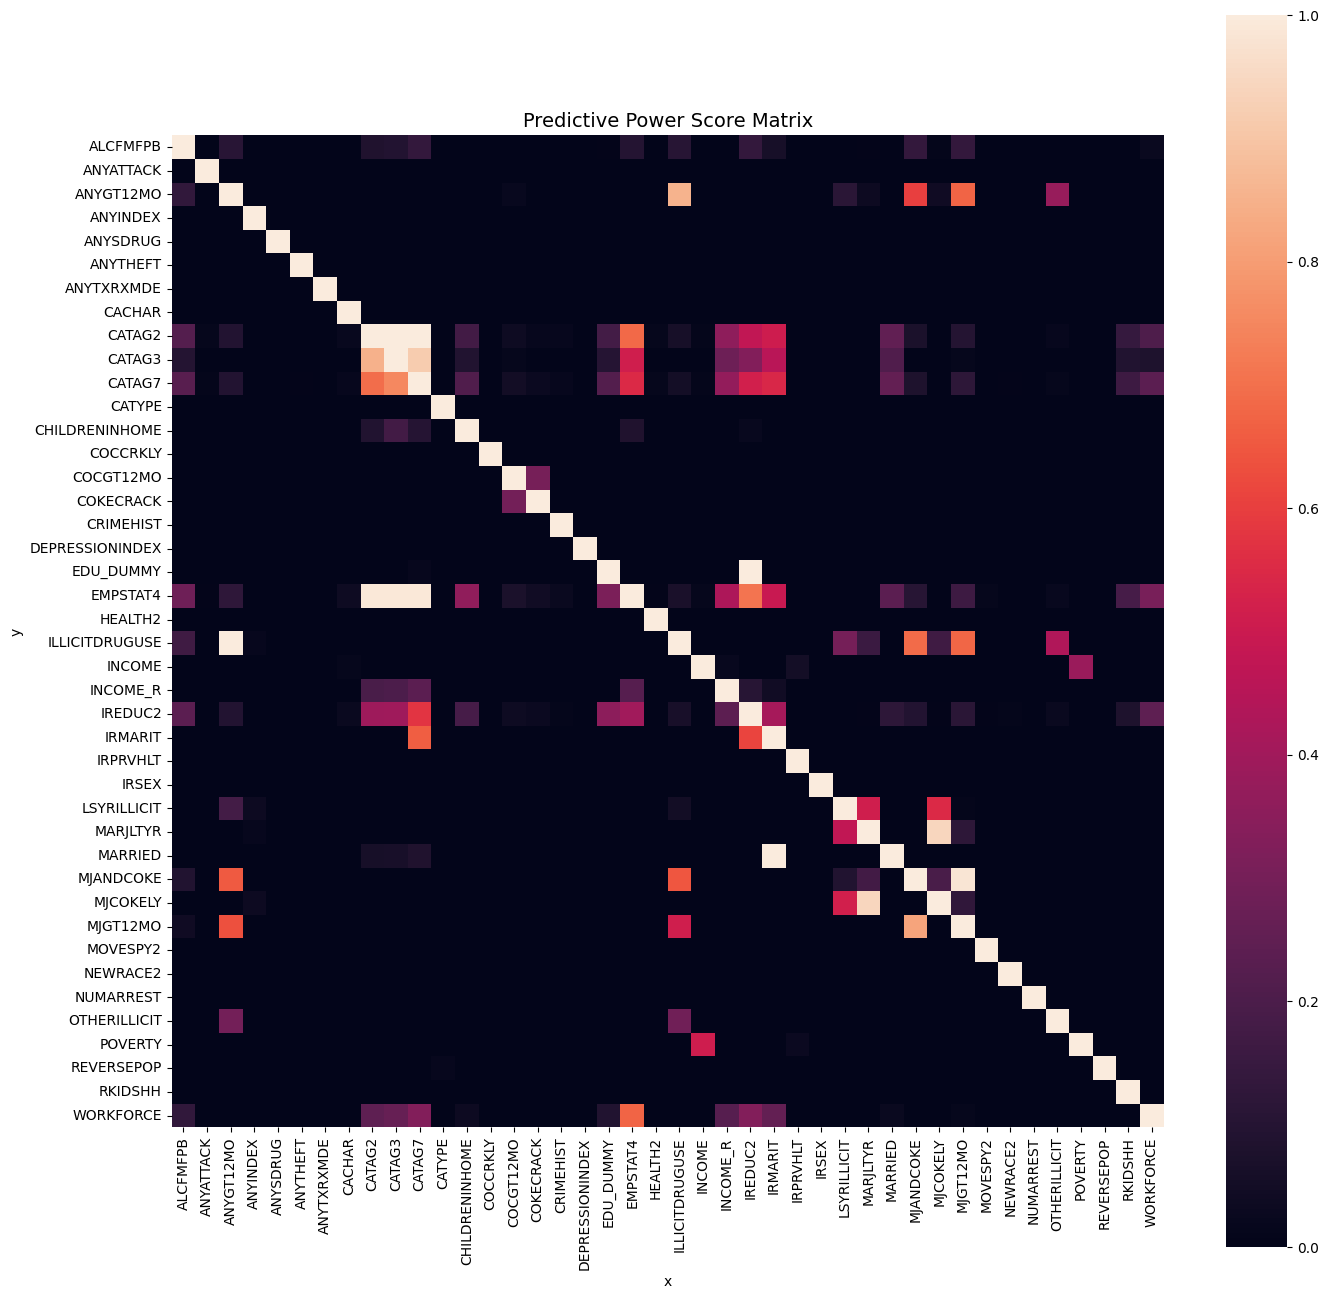

In [21]:
pps_matrix = pps.matrix(df_filtered)
pps_matrix = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
plt.figure(figsize=(16, 16))
sns.heatmap(pps_matrix, vmin=0, vmax=1,square=True)
plt.title('Predictive Power Score Matrix', fontsize=14)
plt.show()

In [22]:
depression_pps_colums = pps_matrix[pps_matrix.columns == 'DEPRESSIONINDEX']
depression_pps_colums = depression_pps_colums.loc[:, depression_pps_colums.ne(0).any(axis=0)]
depression_pps_colums


x,DEPRESSIONINDEX
y,
DEPRESSIONINDEX,1.0


Nawet że PPS nie wykazał związku DEPRESSIONINDEX z ANYTXRXMDE postanawiam usunąć tą kolumne ze względu na możliwe przecieki danych

In [23]:
features_to_drop = ['ANYTXRXMDE']
df_filtered_without_DEPRESSIONINDEX = df_filtered_without_DEPRESSIONINDEX.drop(columns=features_to_drop)
df_filtered = df_filtered.drop(columns=features_to_drop)

# Korelacja Cech

## Wyznaczenie macierzy korelacji

In [24]:
correlation_matrix = df_filtered_without_DEPRESSIONINDEX.corr(method='pearson')
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix, fmt=".2f")
# plt.title("Pearson Correlation Matrix",fontsize=14)
# plt.show()

correlation_matrix2 = df_filtered_without_DEPRESSIONINDEX.corr(method='spearman')
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix2, fmt=".2f")
# plt.title("Spearman Correlation Matrix",fontsize=14)
# plt.show()


In [25]:
corr_threshold = 0.8
corr_pairs = (correlation_matrix.abs() > corr_threshold) & (correlation_matrix < 1)
corr_pairs = corr_pairs.unstack().reset_index()
corr_pairs = corr_pairs[corr_pairs[0]]
corr_pairs = corr_pairs[corr_pairs.level_0 < corr_pairs.level_1]
corr_pairs = corr_pairs.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})

corr_pairs2 = (correlation_matrix2.abs() > corr_threshold) & (correlation_matrix2 < 1)
corr_pairs2 = corr_pairs2.unstack().reset_index()
corr_pairs2 = corr_pairs2[corr_pairs2[0]]
corr_pairs2 = corr_pairs2[corr_pairs2.level_0 < corr_pairs2.level_1]
corr_pairs2 = corr_pairs2.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})

corr_pairs = pd.concat([corr_pairs, corr_pairs2])
corr_pairs = corr_pairs.drop_duplicates()


## Grupowanie zmiennych zależnych i redukcja cech

In [26]:

graph = nx.Graph()

features = pd.concat([corr_pairs['Feature 1'], corr_pairs['Feature 2']]).unique()
graph.add_nodes_from(features)

edges = corr_pairs[['Feature 1', 'Feature 2']].values
graph.add_edges_from(edges)

connected_components = list(nx.connected_components(graph))

groups_df = pd.DataFrame({
    "Group": [f"Group {i+1}" for i in range(len(connected_components))],
    "Features": [", ".join(sorted(component)) for component in connected_components]
})

pd.set_option('display.max_colwidth', None)
groups_df


,Group,Features
0,Group 1,"CATAG2, CATAG3, CATAG7, EMPSTAT4, IREDUC2, IRMARIT"
1,Group 2,"ANYGT12MO, ILLICITDRUGUSE, MJANDCOKE, MJGT12MO"
2,Group 3,"LSYRILLICIT, MARJLTYR, MJCOKELY"


In [27]:
depression_corr1 = df_filtered.corr(method='pearson')['DEPRESSIONINDEX'].abs()
depression_corr2 = df_filtered.corr(method='spearman')['DEPRESSIONINDEX'].abs()

combined_corr = pd.concat([depression_corr1, depression_corr2], axis=1).max(axis=1)
combined_corr.sort_values(ascending=False, inplace=True)
combined_corr

DEPRESSIONINDEX    1.000000
OTHERILLICIT       0.183496
ILLICITDRUGUSE     0.182700
ANYGT12MO          0.176620
MJANDCOKE          0.149675
IRSEX              0.148019
MJGT12MO           0.142717
LSYRILLICIT        0.136487
ANYINDEX           0.130577
HEALTH2            0.112893
MJCOKELY           0.102968
MARJLTYR           0.099455
COCGT12MO          0.097212
ANYATTACK          0.097122
ALCFMFPB           0.081427
IRMARIT            0.079328
COKECRACK          0.072683
IREDUC2            0.072569
COCCRKLY           0.061653
MOVESPY2           0.061419
ANYTHEFT           0.059162
CRIMEHIST          0.057522
CATAG7             0.050720
ANYSDRUG           0.050480
WORKFORCE          0.036861
EMPSTAT4           0.035647
NUMARREST          0.033664
EDU_DUMMY          0.031859
INCOME             0.031781
IRPRVHLT           0.030567
RKIDSHH            0.028870
MARRIED            0.027159
CATAG2             0.026986
CATAG3             0.021333
POVERTY            0.020303
NEWRACE2           0

In [28]:
best_features = []
for group in connected_components:
    group_corr = combined_corr[list(group)]  
    best_feature = group_corr.idxmax()  
    best_features.append(best_feature)

best_features_df = pd.DataFrame({
    "Group": [f"Group {i+1}" for i in range(len(best_features))],
    "Best Feature": best_features
})

best_features_df

,Group,Best Feature
0,Group 1,IRMARIT
1,Group 2,ILLICITDRUGUSE
2,Group 3,LSYRILLICIT


In [29]:
all_unique_features = list(set([feature for group in connected_components for feature in group]))
features_to_drop = list(set(all_unique_features) - set(best_features))
features_to_drop

['IREDUC2',
 'ANYGT12MO',
 'MJANDCOKE',
 'CATAG3',
 'MJCOKELY',
 'MARJLTYR',
 'CATAG7',
 'MJGT12MO',
 'CATAG2',
 'EMPSTAT4']

# Wybór kluczowych cech dla modelu

In [30]:
new_correlation_matrix = df_filtered.drop(columns=features_to_drop)

interesting_columns = []

## Korelacja "spearman" dla cech najbardziej skorelowanych z DEPRESSIONINDEX

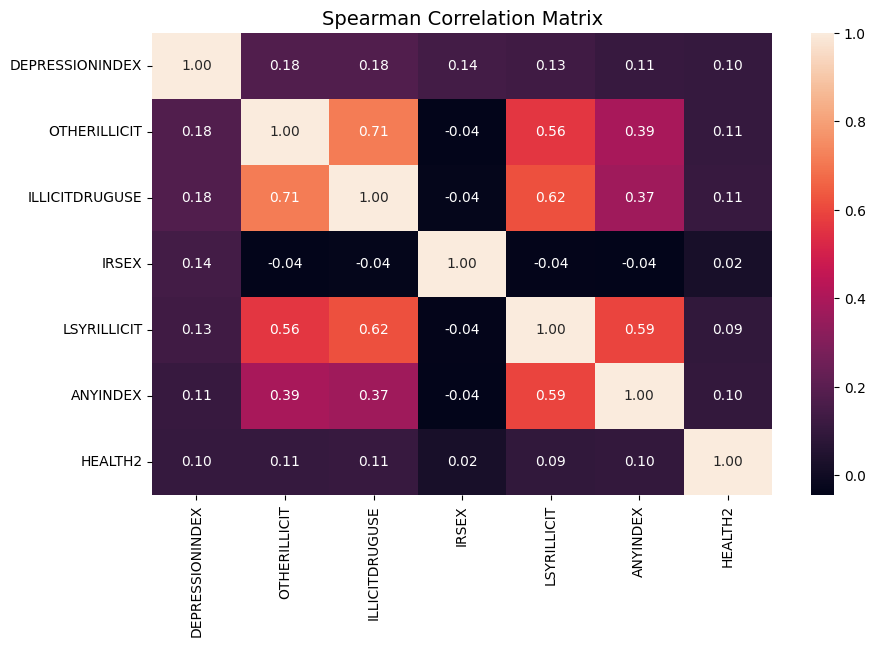

In [31]:
list_to_check = new_correlation_matrix.corr(method='spearman')['DEPRESSIONINDEX'].abs().sort_values(ascending=False)
list_to_check_new = list_to_check[:7].index.tolist()
interesting_columns.append(list_to_check_new)
corr_data = new_correlation_matrix[list_to_check_new]
corr_data.corr(method='spearman')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(method='spearman'), fmt=".2f", annot=True)
plt.title("Spearman Correlation Matrix",fontsize=14)
plt.show()

## Korelacja "pearson" dla cech najbardziej skorelowanych z DEPRESSIONINDEX

In [32]:
# list_to_check = new_correlation_matrix.corr(method='pearson')['DEPRESSIONINDEX'].abs().sort_values(ascending=False)
# list_to_check_new = list_to_check[:7].index.tolist()
# interesting_columns.append(list_to_check_new)
# corr_data = new_correlation_matrix[list_to_check_new]
# corr_data.corr(method='pearson')
# plt.figure(figsize=(10, 6))
# sns.heatmap(corr_data.corr(method='pearson'), fmt=".2f", annot=True)
# plt.title("Spearman Correlation Matrix",fontsize=14)
# plt.show()

## Test Manna-Whitneya dla danych binarnych i DEPRESSIONINDEX

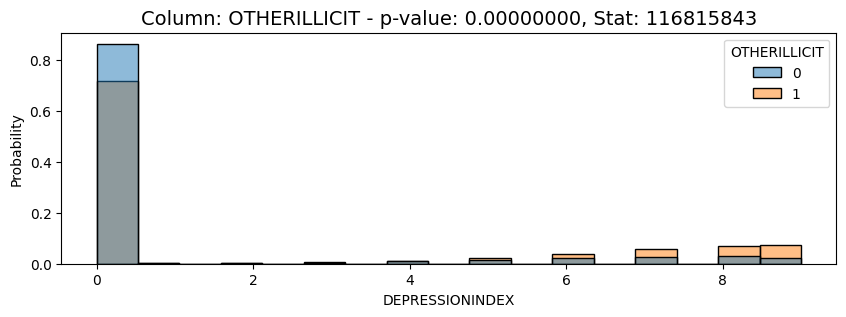

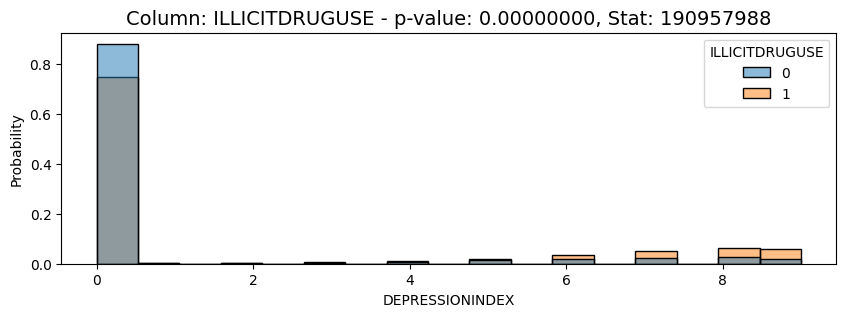

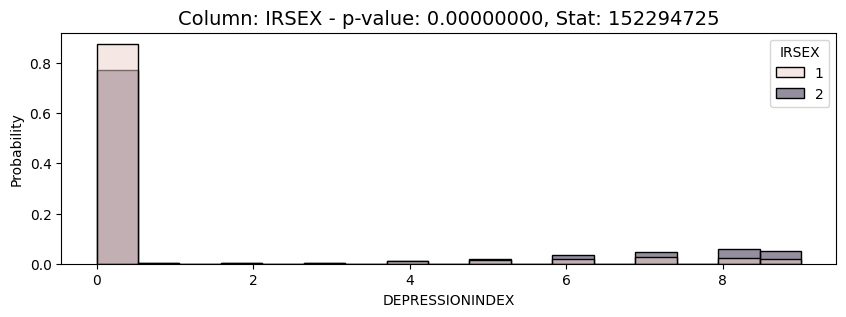

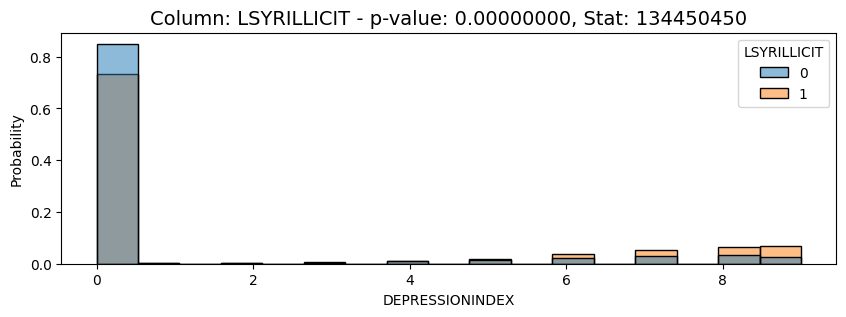

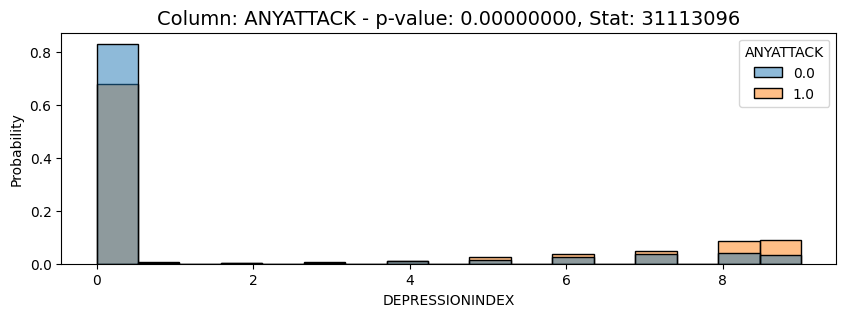

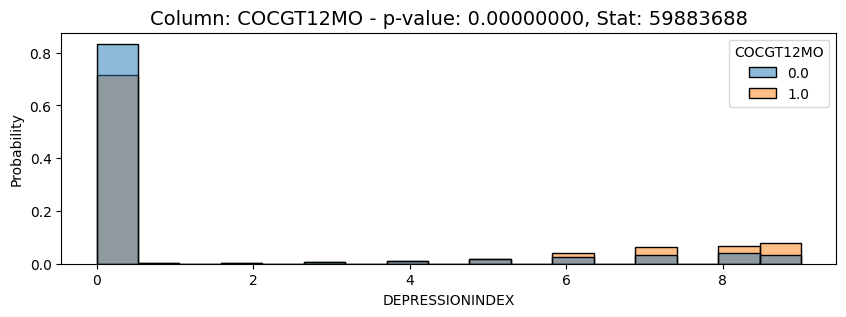

In [33]:
df_filtered = new_correlation_matrix

p_values = []

for column in df_filtered.columns:
    if column != 'DEPRESSIONINDEX':
        unique_values = df_filtered[column].unique()
        if len(unique_values) == 2:  
            group1 = df_filtered[df_filtered[column] == unique_values[0]]['DEPRESSIONINDEX']
            group2 = df_filtered[df_filtered[column] == unique_values[1]]['DEPRESSIONINDEX']
            stat, p_value = mannwhitneyu(group1, group2)
            p_values.append((column, p_value))


p_values_sorted = sorted(p_values, key=lambda x: x[1])
top_5_features = p_values_sorted[:6]
interesting_columns.append([column for column, p_value in top_5_features])
for column, p_value in top_5_features:
        if column != 'DEPRESSIONINDEX':
            unique_values = df_filtered[column].unique()
            group1 = df_filtered[df_filtered[column] == unique_values[0]]['DEPRESSIONINDEX']
            group2 = df_filtered[df_filtered[column] == unique_values[1]]['DEPRESSIONINDEX']
            stat, p_value = mannwhitneyu(group1, group2)
            title = f'Column: {column} - p-value: {p_value:.8f}, Stat: {stat:.0f}'   

            plt.figure(figsize=(10, 3))
            sns.histplot(df_filtered, x='DEPRESSIONINDEX', hue=column, stat='probability', common_norm=False)
            plt.title(title, fontsize=14)
            plt.show()
            


## Test Kruskala-Wallisa dla danych kategorycznych i DEPRESSIONINDEX

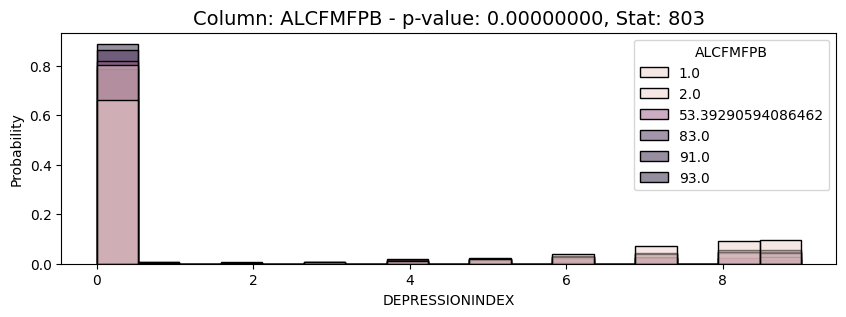

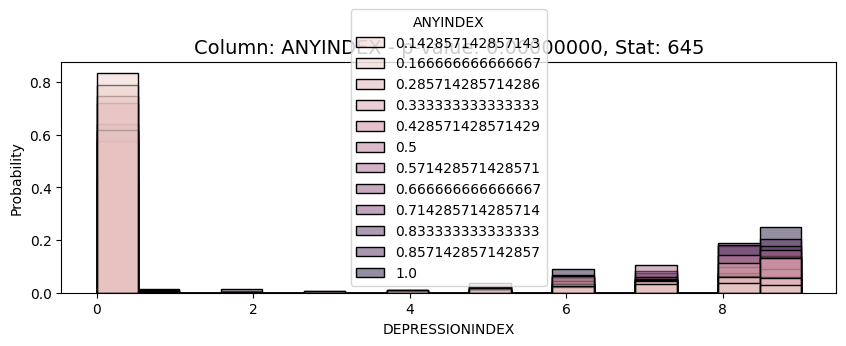

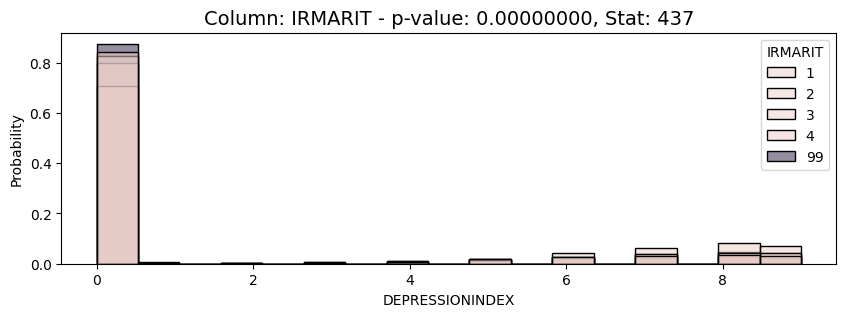

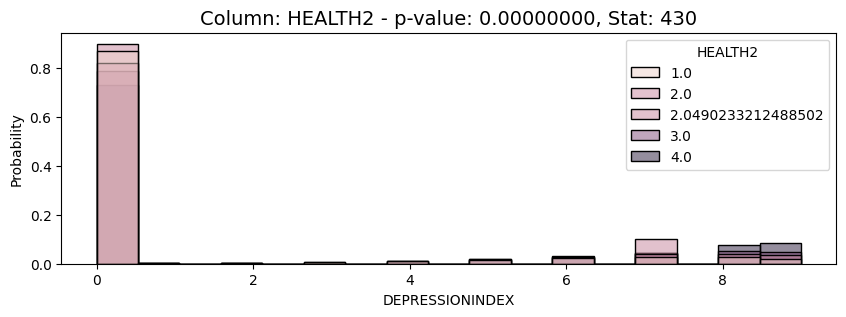

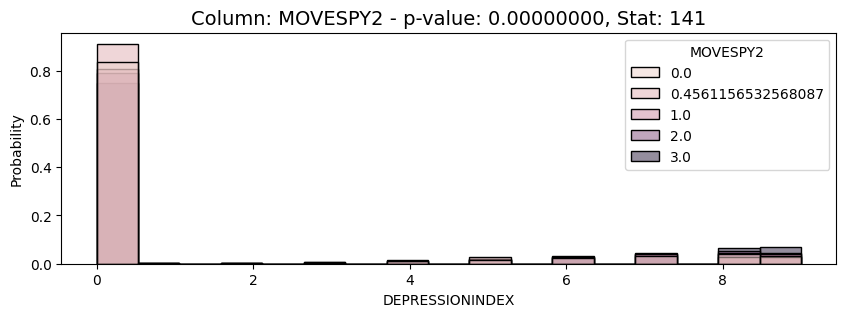

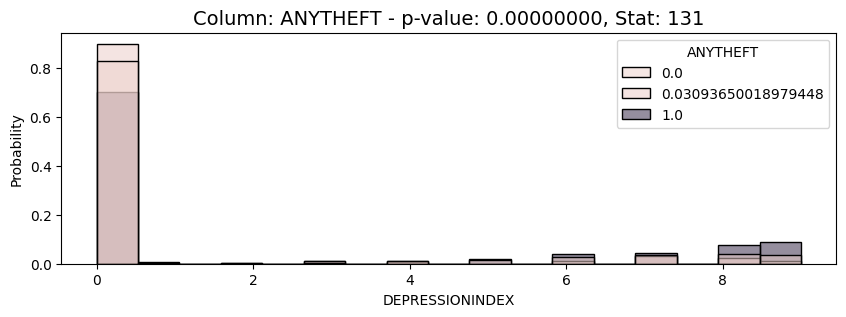

In [34]:
df_filtered = new_correlation_matrix
y = df_filtered['DEPRESSIONINDEX']
p_values = []

for column in df_filtered.columns:
    if column != 'DEPRESSIONINDEX':
        unique_values = df_filtered[column].unique()
        if len(unique_values) > 2:
            groups = [df_filtered[df_filtered[column] == value]['DEPRESSIONINDEX'] for value in unique_values]
            stat, p_value = kruskal(*groups)
            p_values.append((column, p_value))

p_values_sorted = sorted(p_values, key=lambda x: x[1])
top_5_features = p_values_sorted[:6]
interesting_columns.append([column for column, p_value in top_5_features])
for column, p_value in top_5_features:
        if column != 'DEPRESSIONINDEX':
            unique_values = df_filtered[column].unique()
            groups = [df_filtered[df_filtered[column] == value]['DEPRESSIONINDEX'] for value in unique_values]
            stat, p_value = kruskal(*groups)
            title = f'Column: {column} - p-value: {p_value:.8f}, Stat: {stat:.0f}'   

            plt.figure(figsize=(10, 3))
            sns.histplot(df_filtered, x='DEPRESSIONINDEX', hue=column, stat='probability', common_norm=False)
            plt.title(title, fontsize=14)
            plt.show()

## Wyniki

In [35]:
flat_list = [item for sublist in interesting_columns for item in sublist]
flat_list = [item for item in flat_list if item != 'DEPRESSIONINDEX']
series = pd.Series(flat_list)
counts = series.value_counts()

index = counts[:6].index.tolist()
index

['OTHERILLICIT',
 'ILLICITDRUGUSE',
 'IRSEX',
 'LSYRILLICIT',
 'ANYINDEX',
 'HEALTH2']

# Modelowanie danych

## Podział zbioru na test, train, val

In [36]:
index.append('DEPRESSIONINDEX')
Boost_data = df_filtered[index]

majority_class = Boost_data[Boost_data['DEPRESSIONINDEX'] == 0]
minority_class = Boost_data[Boost_data['DEPRESSIONINDEX'] != 0]

minority_oversampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)

Boost_data_2 = pd.concat([majority_class, minority_oversampled])

X = Boost_data_2.drop(columns='DEPRESSIONINDEX')
y = Boost_data_2['DEPRESSIONINDEX']

y_binary = (y != 0).astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_2, X_val_2, y_test_2, y_val_2 = train_test_split(X_test_2, y_test_2, test_size=0.5, random_state=42)


In [37]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(48734, 6) (6092, 6) (6092, 6)
(48734,) (6092,) (6092,)


## Sprawdzenie rozkładu danych

### Test Kolmogorowa-Smirnowa by sprawdzić czy rozkład zmiennej Y jest taki sam

In [38]:
stat, p_value = ks_2samp(y_train, y_val)
print(f'Test KS dla Train vs Validation: p-value={p_value}')

stat, p_value = ks_2samp(y_train, y_test)
print(f'Test KS dla Train vs Test: p-value={p_value}')

stat, p_value = ks_2samp(y_val, y_test)
print(f'Test KS dla Validation vs Test: p-value={p_value}')

Test KS dla Train vs Validation: p-value=0.9996798592546141
Test KS dla Train vs Test: p-value=0.9999999922751829
Test KS dla Validation vs Test: p-value=0.9999999999999996


### Test PCA by sprawdzić czy rozkładny zmiennej X są takie same

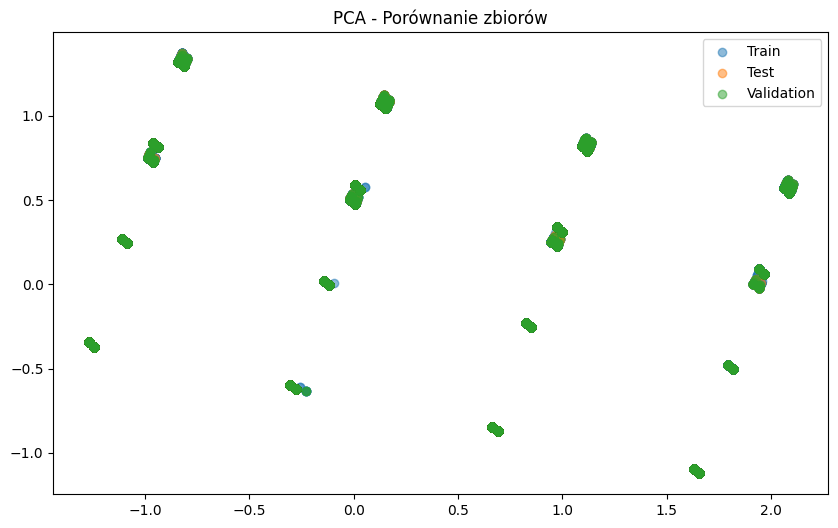

In [39]:
pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label='Train', alpha=0.5)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label='Test', alpha=0.5)
plt.scatter(X_val_pca[:, 0], X_val_pca[:, 1], label='Validation', alpha=0.5)

plt.legend()
plt.title('PCA - Porównanie zbiorów')
plt.show()

# Model do kalsyfikacji jest/nie ma depresji

## Model CatBoost

In [40]:
model = CatBoostClassifier(
    iterations=1000,
    depth=12,
    learning_rate=0.1,
    verbose=50,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))

0:	learn: 0.6835953	total: 54.3ms	remaining: 5.37s
50:	learn: 0.6355669	total: 247ms	remaining: 237ms
99:	learn: 0.6349432	total: 420ms	remaining: 0us
              precision    recall  f1-score   support

           0       0.62      0.65      0.64      3022
           1       0.64      0.61      0.62      3070

    accuracy                           0.63      6092
   macro avg       0.63      0.63      0.63      6092
weighted avg       0.63      0.63      0.63      6092



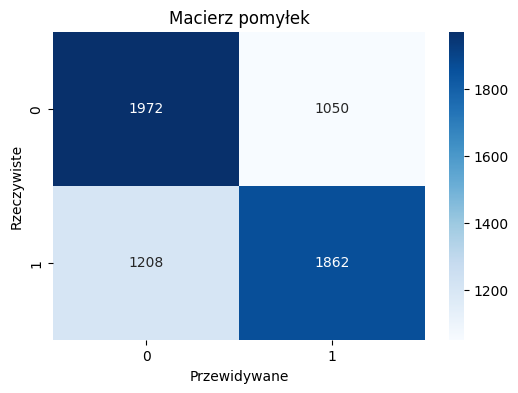

In [41]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model OLS

In [42]:
X_train_ols = sm.add_constant(X_train)
X_val_ols = sm.add_constant(X_val)

ols_model = sm.OLS(y_train, X_train_ols).fit()
predictions = ols_model.predict(X_val_ols)

probabilities = 1 / (1 + np.exp(-predictions))

threshold = 0.61
y_pred = (probabilities >= threshold).astype(int)


print(ols_model.summary())



                            OLS Regression Results                            
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     938.2
Date:                Wed, 15 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:04:52   Log-Likelihood:                -32707.
No. Observations:               48734   AIC:                         6.543e+04
Df Residuals:                   48727   BIC:                         6.549e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0392      0.009     -4.

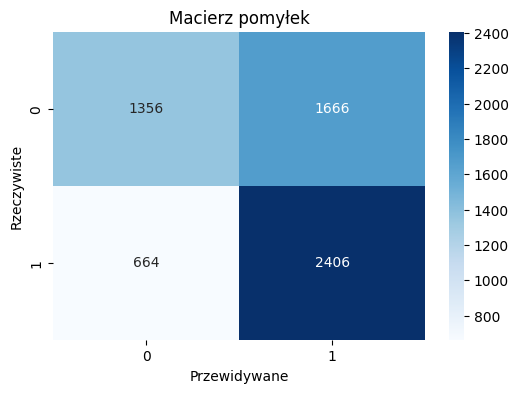

In [43]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model XGB

In [44]:
model = xgb.XGBClassifier(n_estimators=1000, max_depth=12, learning_rate=0.1, verbosity=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

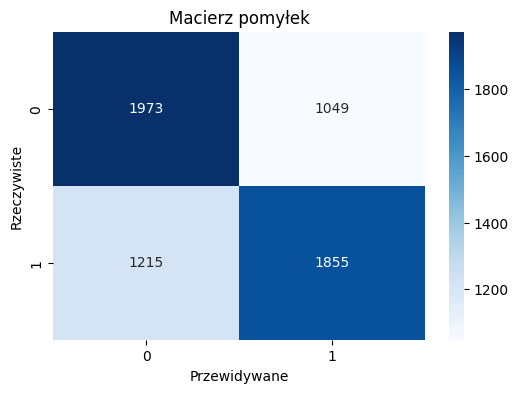

In [45]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

# Model do kalsyfikacji skali depresji w całym zbiorze

## Model CatBoost

In [46]:
model = CatBoostClassifier(
    iterations=1000,
    depth=12,
    learning_rate=0.1,
    verbose=50,
)

model.fit(X_train_2, y_train_2)

y_pred_2 = model.predict(X_val_2)

print(classification_report(y_val_2, y_pred_2))

0:	learn: 2.0879394	total: 19.4ms	remaining: 1.92s
50:	learn: 1.5162471	total: 1.81s	remaining: 1.74s
99:	learn: 1.5086564	total: 3.58s	remaining: 0us
              precision    recall  f1-score   support

           0       0.52      0.96      0.68      3022
           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00       170
           5       0.00      0.00      0.00       269
           6       0.67      0.01      0.02       453
           7       0.28      0.02      0.03       644
           8       0.35      0.06      0.10       737
           9       0.33      0.19      0.24       609

    accuracy                           0.51      6092
   macro avg       0.21      0.12      0.11      6092
weighted avg       0.41      0.51      0.38      6092



/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

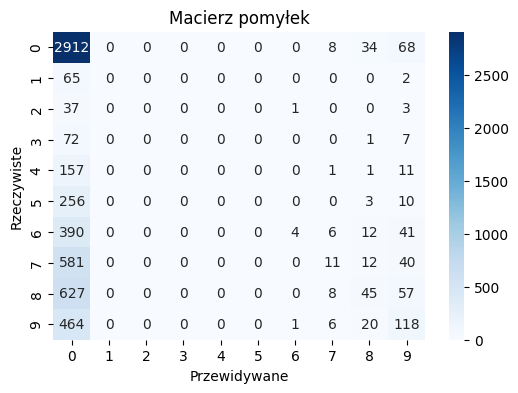

In [47]:
cm = confusion_matrix(y_val_2, y_pred_2)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model OLS

In [48]:
X_train_ols = sm.add_constant(X_train_2)
X_val_ols = sm.add_constant(X_val_2)

ols_model = sm.OLS(y_train_2, X_train_ols).fit()
predictions = ols_model.predict(X_val_ols)

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     1254.
Date:                Wed, 15 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:04:58   Log-Likelihood:            -1.2917e+05
No. Observations:               48734   AIC:                         2.584e+05
Df Residuals:                   48727   BIC:                         2.584e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1892      0.066    -17.

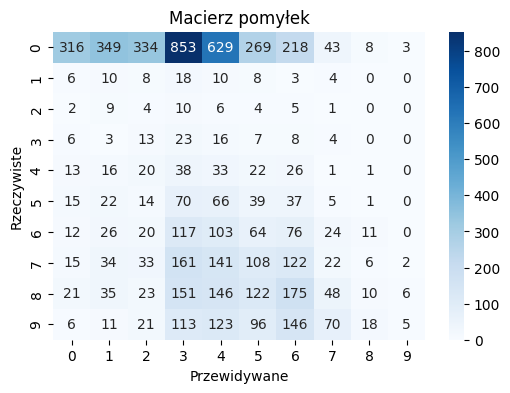

In [49]:
min_val = predictions.min()
max_val = predictions.max()

bins = np.linspace(min_val, max_val, num=10)
y_pred_classes = np.digitize(predictions, bins=bins, right=True) 

conf_matrix = confusion_matrix(y_val_2, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model XGB

In [ ]:
model = xgb.XGBClassifier(n_estimators=1000, max_depth=12, learning_rate=0.1, verbosity=1)
model.fit(X_train_2, y_train_2)
y_pred = model.predict(X_val_2)

print(classification_report(y_val_2, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.96      0.68      3022
           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        80
           4       0.00      0.00      0.00       170
           5       0.00      0.00      0.00       269
           6       0.38      0.01      0.03       453
           7       0.28      0.02      0.03       644
           8       0.36      0.07      0.11       737
           9       0.33      0.20      0.25       609

    accuracy                           0.51      6092
   macro avg       0.19      0.13      0.11      6092
weighted avg       0.39      0.51      0.38      6092



/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krzysztof/.pyenv/versions/3.7.12/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

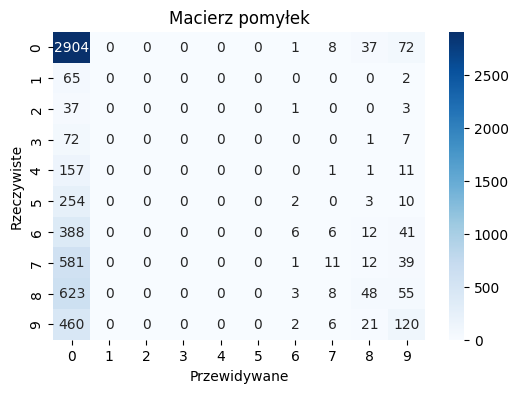

In [51]:
conf_matrix = confusion_matrix(y_val_2, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

# Model do kalsyfikacji skali depresji gdy stwierdzono depresje

## Podział zbioru na test, train, val

In [69]:
# Depression_column.append('DEPRESSIONINDEX')
new_boost_data = df_filtered_for_depressio_scale[Depression_column]

new_boost_data = new_boost_data[new_boost_data['DEPRESSIONINDEX'] != 0]

groups = new_boost_data.groupby('DEPRESSIONINDEX')

max_samples_per_class = max(groups.size())  

balanced_data = groups.apply(
    lambda x: resample(x, replace=True, n_samples=max_samples_per_class, random_state=42)
)

balanced_data = balanced_data.reset_index(drop=True)

X = balanced_data.drop(columns='DEPRESSIONINDEX')
y = balanced_data['DEPRESSIONINDEX']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



In [70]:
new_boost_data.head()

,YOWRSATP,YOWRSPLN,YO_MDEA3,YO_MDEA4,YO_MDEA6,ADWRELES,ADWRSTHK,ADWRSLEP,ADWRDLOT,Somatic,DEPRESSIONINDEX
5,2.0,2.0,1.272696,1.117627,1.149742,2.000000,1.000000,2.000000,1.000000,0.138812,5
29,2.0,2.0,1.272696,1.117627,1.149742,1.000000,1.000000,1.000000,1.000000,0.138812,9
46,2.0,2.0,1.272696,1.117627,1.149742,2.000000,2.000000,1.000000,2.000000,0.138812,5
54,2.0,2.0,1.272696,1.117627,1.149742,1.000000,2.000000,1.000000,2.000000,0.138812,7
55,2.0,2.0,1.000000,1.000000,1.000000,1.389991,1.612099,1.182626,1.459754,2.000000,7


In [71]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(11181, 10) (1398, 10) (1398, 10)
(11181,) (1398,) (1398,)


## Model CatBoost

In [74]:
model = CatBoostClassifier(
    iterations=1000,
    depth=12,
    learning_rate=0.1,
    verbose=50,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))

0:	learn: 2.0538681	total: 17.3ms	remaining: 17.3s
50:	learn: 1.4526108	total: 1.11s	remaining: 20.6s
100:	learn: 1.4381967	total: 2.06s	remaining: 18.4s
150:	learn: 1.4328199	total: 3.41s	remaining: 19.2s
200:	learn: 1.4309372	total: 4.94s	remaining: 19.7s
250:	learn: 1.4300094	total: 6.26s	remaining: 18.7s
300:	learn: 1.4294646	total: 7.94s	remaining: 18.4s
350:	learn: 1.4291242	total: 9.1s	remaining: 16.8s
400:	learn: 1.4288756	total: 10.2s	remaining: 15.3s
450:	learn: 1.4286886	total: 11.4s	remaining: 13.8s
500:	learn: 1.4285518	total: 12.5s	remaining: 12.5s
550:	learn: 1.4284428	total: 13.7s	remaining: 11.2s
600:	learn: 1.4283535	total: 14.9s	remaining: 9.86s
650:	learn: 1.4282772	total: 16.1s	remaining: 8.63s
700:	learn: 1.4282140	total: 17.3s	remaining: 7.4s
750:	learn: 1.4281617	total: 18.5s	remaining: 6.14s
800:	learn: 1.4281157	total: 19.6s	remaining: 4.87s
850:	learn: 1.4280748	total: 20.7s	remaining: 3.63s
900:	learn: 1.4280417	total: 21.9s	remaining: 2.41s
950:	learn: 1.42

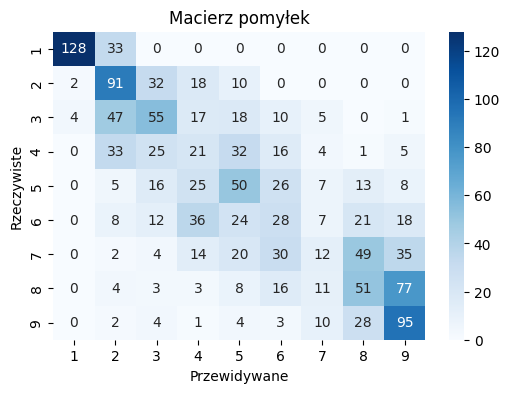

In [75]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()

## Model OLS

In [76]:
X_train_ols = sm.add_constant(X_train)
X_val_ols = sm.add_constant(X_val)

ols_model = sm.OLS(y_train, X_train_ols).fit()
predictions = ols_model.predict(X_val_ols)

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:        DEPRESSIONINDEX   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     781.0
Date:                Wed, 15 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:29:38   Log-Likelihood:                -23510.
No. Observations:               11181   AIC:                         4.704e+04
Df Residuals:                   11170   BIC:                         4.712e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8694      0.255     73.907      0.0

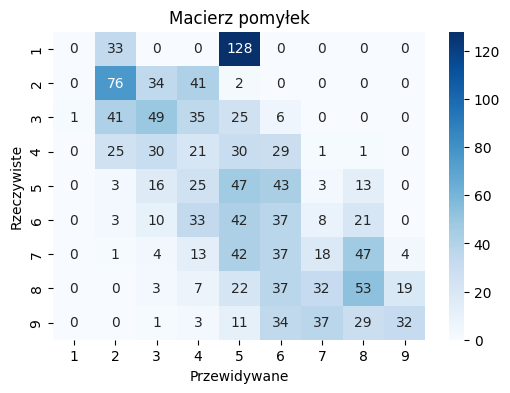

In [79]:
min_val = predictions.min()
max_val = predictions.max()

bins = np.linspace(min_val, max_val, num=9)
y_pred_classes = np.digitize(predictions, bins=bins, right=True) +1

conf_matrix = confusion_matrix(y_val, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidywane')
plt.ylabel('Rzeczywiste')
plt.show()